In [190]:
#This Cell Defines the parameters
import time
import cPickle as pickle
#import cv2
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from scipy.integrate import RK45
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.linear_model import LinearRegression

#Parameters
eta = 1.0					#Dispersion Parameter
n = 36						#Number of x-components
x_0 = np.zeros(n)			#Initial x
#x_0[0] = 0.99 
v_0 = x_0 					#v = x * (Integrating Factor). In this case IF = exp(eta*t), so IF(0) = 1 
sigma = 0.5					#SD of noise
S = np.zeros((n,n))			#covariance matrix for the noise
for i in xrange(5):
	S[i][i] = sigma 
h = 0.005					#Time step
h_range = np.arange(0.005, 0.025, 0.005)
t_final = 20.				#Terminal simulation time
nsteps = int(t_final / h)	#Number of steps
l = 0.8						#mixing parameter for the stratification algorithm
#Setup of Stratification
strata = [[-0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75], [-0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75]] 		#Boundary points of the strata in x_0 (or also later coordinates)
nu_0_weights = 1. / (len(strata) + 1.) * np.ones(len(strata) + 1)
n_exits = 20
n_iterations = 50
bin_edges = np.arange(-1., 1., 0.025)
bin_edges_later_vars = np.arange(-.3, .3, 0.0075)  #'later vars' refers to x_1,...,x_n. only x_0 has a direct source of noise, so the range it explores is different
bin_diff = 0.025
bin_diff_later_vars = 0.0075

J = (len(strata[0]) + 1)**2
#Initialize the collection of injection measures and weights
#The initial nu is a single point in each region, with weight 1
nu_0_points = []
nu_0_probs = []
K = len(strata[0]) + 1
for i in xrange(K-1):
    for j in xrange(K-1): 
        y = np.zeros(n)
        y[0] = strata[0][i] - 0.1
        y[4] = strata[1][j] - 0.1
        nu_0_points.append([y])
        nu_0_probs.append([1.])
    y = np.zeros(n)
    y[0] = strata[0][i] - 0.1
    y[4] = strata[1][K-2] + 0.1
    nu_0_points.append([y])
    nu_0_probs.append([1.])
for j in xrange(K-1): 
    y = np.zeros(n)
    y[0] = strata[0][K-2] + 0.1
    y[4] = strata[1][j] - 0.1
    nu_0_points.append([y])
    nu_0_probs.append([1.])
y = np.zeros(n)
y[0] = strata[0][K-2] + 0.1
y[4] = strata[1][K-2] + 0.1
nu_0_points.append([y])
nu_0_probs.append([1.])


In [191]:
#This Cell contains Definitions of the main functions
def f_IFRK(y, t):
    d = np.zeros(n)
    d[0] = (y[1] - y[n-2]) * y[n-1] + 4 * y[0] - 16 * (y[0]*y[0]*y[0]) #RK4 function for a double well in 2 coordinates
    d[1] = (y[2] - y[n-1]) * y[0] - y[1]
    d[n-1] = (y[0] - y[n-3]) * y[n-2] - y[n-1]
    for i in range(2, n-1):
        d[i] = (y[i+1] - y[i-2]) * y[i-1] - y[i]
    d[4] = (y[5] - y[2]) * y[3] + 4 * y[4] - 16 * (y[4]*y[4]*y[4])
    return d

def g_IFRK(y, t): 
	noise = np.zeros(n)
	for i in xrange(n):
		noise[i] = S[i][i] * np.exp(eta * t)
	return noise


#The function that moves a stochastic system dX = fdt + gdW ahead by time h via Runge-Kutta
def RK_SDE_Step(y, t, f, g, h): 
	m = len(y)
	dW = np.random.normal(0.0, np.sqrt(h), m)
	b = np.random.binomial(1, 0.5)	#The binary RV used in the improved Euler RK method for sde's
	if b == 0:
		b = -1
	K_1 = h * f(y, t) + (dW - np.sqrt(h) * b) * g(y, t) 
	K_2 = h * f(y + K_1, t + h) + (dW + np.sqrt(h)*b) * g(y + K_1, t + h)
	y_new = y + 0.5 * (K_1 + K_2) 
	return y_new

#The Function that evolves the deterministic part of an SDE only by time h using RK4
def RK_4_Step(y, t, f, h):
	K_1 = h * f(y, t)
	K_2 = h * f(y + 0.5 * K_1, t + 0.5 * h)
	K_3 = h * f(y + 0.5 * K_2, t + 0.5 * h)
	K_4 = h * f(y + K_3, t + h)
	y_new = y + (1.0 / 6.0) * (K_1 + 2. * K_2 + 2. * K_3 + K_4)
	return y_new

#The test function to be used in the stratified algorithm
def phi(x):
	return np.sum(x[0]**2)


#This function uses the ones above to generate the data (x, t) of the system evolving in time for a given step size
def RK_SDE_Sim(y_0, nsteps, f, g, h):
	x = np.zeros((nsteps,n))
	x[0] = x_0
	v = x_0
	for i in  xrange(nsteps-1): 
		v = x[i]
		v = RK_SDE_Step(v, 0., f, g, h)
		x[i + 1] = np.exp(-1.0 * eta * h) * v 
	t_range = np.arange(0.0, t_final, h)
	return x, t_range

#This function evolves x and t similarly, but by using RK4 on the deterministic part of v, converting back to x, then adding the appropriate noise
def RK_4_Sim(x_0, nsteps, f, S, h, phi, G):
	m = len(x_0)
	mu_estimate = 0.0
	x = np.zeros((nsteps,n))
	x[0] = x_0
	v = x_0
	for i in  xrange(nsteps-1): 
		v = x[i]
		j = idx(x[i], strata)
		v = RK_4_Step(v, 0., f_IFRK, h)
		noise = np.zeros(m)
		for k in xrange(m):
			noise[k] = S[k][k] * np.sqrt(h) * np.random.normal(0., 1.)
		x[i + 1] = v + noise
		l = idx(x[i+1], strata)
		if j != l:
			G[j][l] += 1
		mu_estimate += phi(x[i+1]) / nsteps
	t_range = np.arange(0.0, t_final, h)
	return x, t_range, mu_estimate, G


################################

#Index function returning the current stratum
#Index function returning the current stratum
def idx(y, strata):
    K = len(strata[0]) + 1
    for i in xrange(len(strata[0]) - 1):
        if (strata[0][i] <= y[0] < strata[0][i+1]):
            for k in xrange(len(strata[1]) - 1):
                if (strata[1][k] <= y[4] < strata[1][k+1]):
                    return (i + 1) * K + (k + 1)
            if y[4] >= strata[1][len(strata[1])-1]:
                return (i+1) * K + len(strata[1])
            if y[4] <= strata[1][0]:
                return (i+1)*K
        
    if y[0] < strata[0][0]:
        for k in xrange(len(strata[1]) - 1):
            if (strata[1][k] <= y[4] < strata[1][k+1]):
                return k+1
        if y[4] >= strata[1][len(strata[1])-1]:
            return len(strata[1])
        if y[4] <= strata[1][0]:
            return 0
            
    if y[0] >= strata[0][len(strata[0])-1]:
        for k in xrange(len(strata[1]) - 1):
            if (strata[1][k] <= y[4] < strata[1][k+1]):
                return (K-1) * K + (k + 1)
        if y[4] >= strata[1][len(strata[1])-1]:
            return (K-1) * K + len(strata[1])
        if y[4] <= strata[1][0]:
            return (K-1) * K

###########
#Note: For now, the algorithm will just pick from nu_j with equal probability for all points, and will average the trajectories for each iteration for the final answer

#Draw a sample from the current j-th injection measure
def injection_draw(points, probs):
	num_choices = len(points)
	probs_sum = np.sum(np.array(probs))
	probs_normalized = probs
	for i in xrange(len(probs)):
		probs[i] = probs[i] / probs_sum
	index_chosen = np.random.choice(num_choices, p=probs_normalized)
	return points[index_chosen]

#Run from a starting measure until exiting, return the exit point and the trajectory the particle took
def RK_4_Sim_Exit(strata, nu_points, nu_probs, nu_weights, f, S, h):
	J = (len(strata[0]) + 1)**2
	exit_points = []
	trajectory = []
	for j in xrange(J):
		trajectory.append([])
	exit_times = np.zeros(J)
	test_fcn_avg = np.zeros(n_polys)
	for j in xrange(J):
		test_fcn_avg_current = np.zeros(n_polys)
		prob_sum = np.sum(nu_probs[j])
		if prob_sum <= 1.e-8 :
			nu_points[j] = nu_0_points[j]
			nu_probs[j] = np.ones(len(nu_0_points[j]))
		start_point = injection_draw(nu_points[j], nu_probs[j])
		idx_0 = idx(start_point, strata)
		current_idx = idx_0
		x_current = start_point
		while (current_idx == idx_0):
			trajectory[j].append(x_current)
			test_fcn_avg_current += test_function_values(coef_1, coef_2, coef_3, x_current)
			#compute the next step
			v = x_current
			v = RK_4_Step(v, 0., f_IFRK, h)
			noise = np.zeros(len(v))
			for k in xrange(len(v)):
				noise[k] = S[k][k] * np.sqrt(h) * np.random.normal(0., 1.)
			x_current = v + noise
			#Update the index so the next loop checks if an exit has occurred
			current_idx = idx(x_current, strata)
			exit_times[j] += 1
		test_fcn_avg_current = test_fcn_avg_current * (1. / exit_times[j])
		test_fcn_avg += test_fcn_avg_current * nu_weights[j]
		exit_points.append(x_current)
    
	return exit_points, trajectory, exit_times, test_fcn_avg


#Note: For now at least, the iteration will just run for n_exits excursions in each stratum, so that the number of exit points is controlled. This can be changed later
def RK_4_stratified_iteration(n_exits, strata, nu_points, nu_probs, nu_weights, f, S, h):
	nu_points_next = []
	nu_probs_next = []
	time_spent = np.zeros(J)
	for j in xrange(J):
		nu_points_next.append([])
		nu_probs_next.append([])
	nu_weights_next = np.zeros(J)
	test_fcn_avg = np.zeros(n_polys)
	G = np.zeros((J,J))
	for i in xrange(n_exits):
		exit_points, trajectory, exit_times, test_fcn_avg_current = RK_4_Sim_Exit(strata, nu_points, nu_probs, nu_weights, f, S, h)
		for j in xrange(J):
			exit_idx = idx(exit_points[j], strata)
			nu_points_next[exit_idx].append(exit_points[j])
			nu_probs_next[exit_idx].append(nu_weights[j])
			G[j][exit_idx] += 1.
			time_spent += exit_times
		test_fcn_avg += (1. / n_exits) * test_fcn_avg_current
	#If nu_points_next is empty for some j, replace it with a single point
	for j in xrange(J):
		if len(nu_points_next[j]) == 0:
			nu_points_next[j].append(nu_0_points[j][0])
			nu_probs_next[j].append(1.)
	#Normalize G and compute the weights
	for i in xrange(J):
		row_sum = np.sum(G[i])
		for j in xrange(J):
			G[i][j] = G[i][j] / row_sum
			nu_weights_next[j] += G[i][j] * nu_weights[i]
    
	#Compile the histograms over each excursion
	return nu_points_next, nu_probs_next, nu_weights_next, test_fcn_avg, time_spent

#New function - eigenvector version
def RK_4_stratified_iteration_eig(n_exits, strata, nu_points, nu_probs, nu_weights, f, S, h):
	nu_points_next = []
	nu_probs_next = []
	xi_points = []
	occupation = []    #The list of points in each excursion, for forming the occupation measure
	for j in xrange(J):
		nu_points_next.append([])
		nu_probs_next.append([])
		xi_points.append([])
	time_spent = np.zeros(J)
	nu_weights_next = np.zeros(J)
	test_fcn_avg = np.zeros(n_polys)
	G = np.zeros((J,J))
	for i in xrange(n_exits):
		exit_points, trajectory, exit_times, test_fcn_avg_current = RK_4_Sim_Exit(strata, nu_points, nu_probs, nu_weights, f, S, h)
		for j in xrange(J):
			exit_idx = idx(exit_points[j], strata)
			xi_points[j].append([exit_points[j], exit_idx])
			G[j][exit_idx] += 1.
			time_spent += exit_times
		occupation.append(trajectory)
	#If nu_points_next is empty for some j, replace it with a single point
	#Normalize G and compute the weights
	for i in xrange(J):
		row_sum = np.sum(G[i])
		for j in xrange(J):
			G[i][j] = G[i][j] / row_sum
			nu_weights_next[j] += G[i][j] * nu_weights[i]
    
    #Compute the weights for the eigenvector version
#	evals, evecs = np.linalg.eig(G.T)
#	evec1 = evecs[:,np.isclose(evals, 1)]
#	evec1 = evec1[:,0]
#	nu_weights_next = evec1 / evec1.sum()
    
    #Option - Just use a high power of G instead of the eig function
	for k in xrange(100*J):
		nu_weights_next = np.dot(nu_weights, G)
	nu_weights_next = nu_weights_next / np.sum(nu_weights_next)
    
    #Form the histogram of the occupation measure with the newly calculated weights
	for k in xrange(n_exits):
		for j in xrange(J):
			exit_time = len(occupation[k][j])
			for i in xrange(exit_time):
				x_point = occupation[k][j][i]
				test_fcn_avg += (1. / n_exits) * (1. / exit_time) * nu_weights_next[j] * test_function_values(coef_1, coef_2, coef_3, x_point)

    #Build the new injection measures from xi and nu_weights_next
	for j in xrange(J):
		for i in xrange(n_exits):
			exit_point = xi_points[j][i][0]
			exit_idx = xi_points[j][i][1]
			nu_points_next[exit_idx].append(exit_point)
			nu_probs_next[exit_idx].append(nu_weights_next[j])
            
	for j in xrange(J):
		if len(nu_points_next[j]) == 0:
			nu_points_next[j].append(nu_0_points[j][0])
			nu_probs_next[j].append(1.)
            
    
	#Compile the histograms over each excursion
	return nu_points_next, nu_probs_next, nu_weights_next, test_fcn_avg, time_spent

def RK_4_Stratified(n_iterations, n_exits, strata, nu_points, nu_probs, nu_weights, f, S, h, l):
	nu_points_next, nu_probs_next, nu_weights_next, iteration_hist = RK_4_stratified_iteration(n_exits, strata, nu_points, nu_probs, nu_weights, f_IFRK, S, h)
	H = iteration_hist[0]
	for i in xrange(n_iterations-1):
		nu_points_next, nu_probs_next, nu_weights_next, iteration_hist = RK_4_stratified_iteration(n_exits, strata, nu_points_next, nu_probs_next, nu_weights_next, f, S, h)
		#H = (1. - l) * H + l * iteration_hist[0]
		H += iteration_hist[0]		#Option: Simply average the histogram of all iterations with equal weight, not using lambda (l)
	#Finally, Normalize H so it is a density
	H_sum = 1. * np.sum(H)
	for i in xrange(len(H)):
		H[i] = H[i] / H_sum
	stratified_hist = (H, bin_edges)
	return nu_points_next, nu_probs_next, nu_weights_next, stratified_hist

def TV_dist(hist_1, hist_2):
    l = len(hist_1)
    d = 0.
    for i in xrange(l):
        d += abs(hist_1[i]-hist_2[i]) * bin_diff
    d = d / 2.
    return d

In [192]:
#This cell will generate random polynomial test functions to be used later. 
#Current Plan: Generate and record them here, and use the same test functions for every run later. 
#Curretly, the test functions do not have cross terms in the coordinates, for computational purposes
n = 36
n_polys = 12
max_degree = 3

#coef_1 = np.zeros((n_polys,n))
#coef_2 = np.zeros((n_polys,n))
#coef_3 = np.zeros((n_polys,n))
#
#generate the coefficients for all 10 polynomials
#for i in xrange(n_polys):
#    #Create an array for the coefficients of the order 1 terms
#    for j in xrange(n):
#        coef_1[i][j] = np.random.uniform(0.,1.)
#        coef_2[i][j] = np.random.uniform(0.,1.)
#        coef_3[i][j] = np.random.uniform(0.,1.)
#
#Note: The first 3 test functions will use only coef_1, so they are linear. The next 3 use coef_1 and coef_2, so they are quadratic. 
#Then 6 cubic test functions
#for i in xrange(3):
#    for j in xrange(n):
#        coef_2[i][j] = 0.
#        coef_3[i][j] = 0.
#for i in xrange(3):
#    for j in xrange(n):
#        coef_3[i+3][j] = 0. 

#with open("L96_test_functions_max_degree_3.dat", "wb") as f:
#    pickle.dump([coef_1, coef_2, coef_3], f)

In [292]:
with open("L96_test_functions_max_degree_3.dat", "rb") as f:
    coef = pickle.load(f)
coef_1 = coef[0]
coef_2 = coef[1]
coef_3 = coef[2]
print coef_1[0]

#Function that takes the coefficient arrays and a n-dim point and returns the polynomial value
def poly_n(poly_coef_1, poly_coef_2, poly_coef_3, x):
    poly_sum = 0.
    for j in xrange(n):
        poly_sum += poly_coef_1[j] * x[j]
        poly_sum += poly_coef_2[j] * x[j] * x[j]
        poly_sum += poly_coef_3[j] * x[j] * x[j] * x[j]
    return poly_sum

def test_function_values(coef_1, coef_2, coef_3, x):
    values = np.zeros(3)
    for i in xrange(3):
        values[i] = poly_n(coef_1[3 *i], coef_2[3 * i], coef_3[3 *i], x)
    return values

[0.69606537 0.78760013 0.61247228 0.06431147 0.48002876 0.73071774
 0.67772761 0.5441237  0.68662686 0.15694714 0.8081202  0.10902309
 0.64854003 0.56495641 0.14456955 0.95523132 0.6827482  0.05362998
 0.4131169  0.90634416 0.7727519  0.96634066 0.76459991 0.06073537
 0.67109902 0.62921137 0.66866493 0.6371225  0.52701425 0.85378645
 0.05010802 0.49152286 0.04884116 0.13307387 0.49488826 0.69632816]


In [195]:
#This cell contains the code (commented by default) for testing and plots

#Test Plot, unstratified
#x, t_range, mu_estimate_unstratified = RK_4_Sim(x_0, nsteps, f_IFRK, S, h, phi)
#un_stratified_hist = np.histogram(x[:,0], bins=bin_edges, density=True)
#H = un_stratified_hist[0]
#H_sum = np.sum(H)
#for i in xrange(len(H)):
#	H[i] = H[i] / H_sum
#un_stratified_hist = (H, bin_edges)
#plt.plot(un_stratified_hist[1][1:], un_stratified_hist[0])
#plt.show()

#Test for a single excursion starting in each stratum
#exit_points, trajectory, exit_times, trajectory_hist = RK_4_Sim_Exit(strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
#for j in xrange(J):
#	plt.plot(np.array(trajectory[j])[:,0], xrange(len(trajectory[j])), 'o')
#plt.show()
#plt.plot(trajectory_hist[2][1:], trajectory_hist[0][1], 'o')
#plt.show()


#Iteration_Test
#Optional - Compute some iterations then plot the last one
#Optional - Use the eig version
#n_exits = 20
#n_iterations = 100
#strata = [-0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75] 		#Boundary points of the strata in x_0
#J = len(strata) + 1
#h = 0.025
#nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration_eig(n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
#for i in xrange(n_iterations):
#    nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration_eig(n_exits, strata, nu_points_next, nu_probs_next, nu_weights_next, f_IFRK, S, h)
#    plt.plot(xrange(8), nu_weights_next, 'bo')
#    plt.show()
    
#    raw_input("Press Enter to continue...")

#stratified_mixed_hist = []
#nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration(n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
#hist = iteration_hist[0][0]

#for i in xrange(n_exits):
#    nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration(n_exits, strata, nu_points_next, nu_probs_next, nu_weights_next, f_IFRK, S, h)
#    hist = hist + iteration_hist[0][0]
#    H = hist / (i + 2.)
    #hist = hist / (np.sum(hist) * bin_diff)
#    
#    plt.plot(bin_edges[1:], hist,'o')
#    plt.show()
#    raw_input("Press Enter to continue...")

#for j in xrange(J):
#	plt.hist(np.array(nu_points_next[j])[:,0], bins=bin_edges, weights=np.array(nu_probs_next[j]))
#plt.plot(xrange(J), nu_weights_next)
#plt.plot(iteration_hist[1][1:], iteration_hist[0][0], 'o')
#plt.show()
#iteration_hist[0][3]

#Iteration test - eig version

#Stratified Algorithm Test
#for s in xrange(4):
#	nu_points_next, nu_probs_next, nu_weights_next, stratified_hist = RK_4_Stratified(n_iterations * (s+1), n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h, l)
#	plt.plot(stratified_hist[1][1:], stratified_hist[0])
#plt.show()

#Test for the polynomial generator and test function evaluator
#x = np.ones(n)
#a = test_function_values(coef_1, coef_2, coef_3, x)
#print a

In [196]:
#This Cell will compute and store the main data from a run of the un-stratified algorithm
#h = 0.005
#t_final = 200000
#nsteps = int(t_final / h)
#r = nsteps / 1000
#K = 8
#J = K**2
#strata = [[-1. + (2.* (j+1.) / K) for j in xrange(K-1)], [-1. + (2.* (j+1.) / K) for j in xrange(K-1)]]
#un_stratified_data = []
#un_stratified_data.append([coef_1, coef_2, coef_3])
#print 'Starting'
#for i in xrange(20):
#    print '***'
#    print 200 * i + 0
#    G = np.zeros((J,J))
#    x, t_range, mu_estimate_unstratified, G = RK_4_Sim(x_0, r, f_IFRK, S, h, phi, G)
#    test_fcn_avg = np.zeros(n_polys)
#    for j in xrange(r):
#        test_fcn_avg += (1. / r) * test_function_values(coef_1, coef_2, coef_3, x[j])
#    un_stratified_data.append([test_fcn_avg, G])
    
#    for k in xrange(199):
#        print (200 * i) + k + 1
#        x, t_range, mu_estimate_unstratified, G = RK_4_Sim(x[r-1], r, f_IFRK, S, h, phi, G)
#        test_fcn_avg = np.zeros(n_polys)
#        for j in xrange(r):
#            test_fcn_avg += (1. / r) * test_function_values(coef_1, coef_2, coef_3, x[j])
#        un_stratified_data.append([test_fcn_avg, G])
                
#with open("un_strat_2D_test_functions.dat", "wb") as f:
#    pickle.dump(un_stratified_data, f)

#Note: The G for this run is being computed with 8 strata, as in the first cell

In [94]:
#This Cell will compute and store the main data from a run of the stratified algorithm, for both versions
#stratified_data_eig_comparison = []
#K_range = [2, 4, 8, 16]
#n_exits = 510
#n_iterations = 300
#h = 0.005
#stratified_data = []
#for K in K_range:
#    J = K**2
#    #print K
#    strata = [[-1. + (2.* (j+1.) / K) for j in xrange(K-1)], [-1. + (2.* (j+1.) / K) for j in xrange(K-1)]]
#    nu_0_points = []
#    nu_0_probs = []
#    for i in xrange(K-1):
#        for j in xrange(K-1): 
#            y = np.zeros(n)
#            y[0] = strata[0][i] - (1. / J)
#            y[4] = strata[1][j] - (1. / J)
#            nu_0_points.append([y])
#            nu_0_probs.append([1.])
#        y = np.zeros(n)
#        y[0] = strata[0][i] - (1. / J)
#        y[4] = strata[1][K-2] + (1. / J)
#        nu_0_points.append([y])
#        nu_0_probs.append([1.])
#    for j in xrange(K-1): 
#        y = np.zeros(n)
#        y[0] = strata[0][K-2] + (1. / J)
#        y[4] = strata[1][j] - (1. / J)
#        nu_0_points.append([y])
#        nu_0_probs.append([1.])
#    y = np.zeros(n)
#    y[0] = strata[0][K-2] + (1. / J)
#    y[4] = strata[1][K-2] + (1. / J)
#    nu_0_points.append([y])
#    nu_0_probs.append([1.])
#    nu_0_weights = (1. / J) * np.ones(J)
#    data_current_J = []
    #print [idx(nu_0_points[i][0], strata) for i in xrange(J)]
    
#    nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration(n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
#    data_current_J.append([nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent, J])
    
#    nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, iteration_hist_eig, time_spent_eig = RK_4_stratified_iteration_eig(n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
#    data_current_J.append([nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, iteration_hist_eig, time_spent_eig, J])
    
#    for i in xrange(n_iterations):
#        print i + 1
#        nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration(n_exits, strata, nu_points_next, nu_probs_next, nu_weights_next, f_IFRK, S, h)
#        data_current_J.append([nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent, J])
            
#        nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, iteration_hist_eig, time_spent_eig = RK_4_stratified_iteration_eig(n_exits, strata, nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, f_IFRK, S, h)
#        data_current_J.append([nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, iteration_hist_eig, time_spent_eig, J])
    
#    stratified_data.append(data_current_J)
#with open("l96_4_noise_double_well_2D_strata", "wb") as f:
#    pickle.dump(stratified_data, f)

In [282]:
#Load the un-stratified algorithm data
with open("un_strat_2D_test_functions_05_11.dat", "rb") as f:
    un_stratified_data = pickle.load(f)
#h = 0.005, 500000 steps total, divided into 1200 histograms. Re-started at the origin every 60 histograms, so 20 runs total

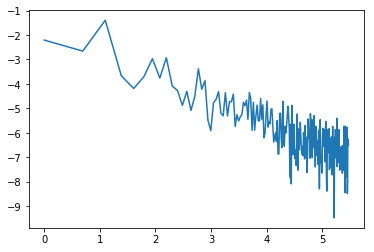

0.009723763600074866
[0.00142557 0.01684402 0.00714101 0.00697579 0.01612744 0.00142561
 0.01592802 0.08129915 0.04865591 0.04735029 0.07817484 0.01504878
 0.00606681 0.04504457 0.02215374 0.02174045 0.04410321 0.0057577
 0.00645373 0.04791437 0.02364117 0.02266189 0.04639482 0.00639823
 0.01754096 0.0882466  0.05288775 0.05101703 0.0848459  0.01683709
 0.00169878 0.01833374 0.00769811 0.00726668 0.01753545 0.00136478]


In [399]:
#This cell is for testing the data from the un-stratified algorithm
test_sum_un_strat = np.zeros((240,3))
test_avg_un_strat = np.zeros((240,3))
G_sum = np.zeros((240,36,36))
G_avg = np.zeros((240,36,36))
test_sum_un_strat[0] = np.array(un_stratified_data[1][0])
test_avg_un_strat[0] = np.array(un_stratified_data[1][0])

test_fcn_nu_sum_un_strat = np.zeros((240,3))
test_fcn_nu_avg_un_strat = np.zeros((240,3))
test_fcn_nu_un_strat_one_stratum_sum = np.zeros((240, J, 3))
test_fcn_nu_un_strat_one_stratum_avg = np.zeros((240, J, 3))

nu_points = un_stratified_data[1][2]
n_points = 0
test_fcn_un_strat_current = np.zeros(3)
test_fcn_un_strat_current_one_stratum = np.zeros((J,3))
for j in xrange(J):
    n_points += len(nu_points[j])
    n_points_current_j = len(nu_points[j])
    for l in xrange(len(nu_points[j])):
        test_fcn_un_strat_current += test_function_values(coef_1, coef_2, coef_3, nu_points[j][l])
        test_fcn_un_strat_current_one_stratum[j] += (1. / n_points_current_j) * test_function_values(coef_1, coef_2, coef_3, nu_points[j][l])
        test_fcn_un_strat_current = (1. / n_points) * test_fcn_un_strat_current
test_fcn_nu_un_strat_one_stratum_sum[0] = test_fcn_un_strat_current_one_stratum
test_fcn_nu_un_strat_one_stratum_avg[0] = test_fcn_nu_un_strat_one_stratum_sum[0]

test_fcn_nu_sum_un_strat[0] = test_fcn_un_strat_current
test_fcn_nu_avg_un_strat[0] = test_fcn_nu_sum_un_strat[0]

G_sum[0] = np.array(un_stratified_data[1][1])
G_avg[0] = G_sum[0]

for i in xrange(239):
    test_sum_un_strat[i+1] = test_sum_un_strat[i] + np.array(un_stratified_data[i+2][0])
    test_avg_un_strat[i+1] = test_sum_un_strat[i+1] / (i + 2.)
    
    nu_points = un_stratified_data[i+2][2]
    n_points = 0
    test_fcn_un_strat_current = np.zeros(3)
    for j in xrange(J):
        n_points += len(nu_points[j])
        n_points_current_j = len(nu_points[j])
        for l in xrange(len(nu_points[j])):
            test_fcn_un_strat_current += test_function_values(coef_1, coef_2, coef_3, nu_points[j][l])
            test_fcn_un_strat_current_one_stratum[j] += (1. / n_points_current_j) * test_function_values(coef_1, coef_2, coef_3, nu_points[j][l])
    test_fcn_nu_un_strat_one_stratum_sum[i+1] = test_fcn_nu_un_strat_one_stratum_sum[i] + test_fcn_un_strat_current_one_stratum
    test_fcn_nu_un_strat_one_stratum_avg[i+1] = test_fcn_nu_un_strat_one_stratum_sum[i+1] / (i+2.)    
            
    test_fcn_un_strat_current = (1. / n_points) * test_fcn_un_strat_current
    test_fcn_nu_sum_un_strat[i+1] = test_fcn_nu_sum_un_strat[i] + test_fcn_un_strat_current
    test_fcn_nu_avg_un_strat[i+1] = test_fcn_nu_sum_un_strat[i+1] / (i + 2.)
        
    G_sum[i+1] = G_sum[i] + np.array(un_stratified_data[i+2][1])
    G_avg[i+1] = G_sum[i+1] / (i + 2.)
#plt.plot(np.log(xrange(239)), [np.log(np.sum(abs(test_avg_un_strat[i+1] - test_avg_un_strat[i]))) for i in xrange(239)])
plt.plot(np.log(xrange(239)), [np.log(np.sum(abs(test_fcn_nu_avg_un_strat[i+1] - test_fcn_nu_avg_un_strat[i]))) for i in xrange(239)])
plt.show()
print test_avg_un_strat[239][0]
for i in xrange(36):
    G_avg[239][i] = G_avg[239][i] / np.sum(G_avg[239][i])
weights_true = np.dot(np.ones(36),np.linalg.matrix_power(G_avg[239],2000))
weights_true = weights_true / (np.sum(weights_true))
print weights_true

#Note: Compute the transition matrix over the un-stratified run, and use those as the 'true' weights in the next graph

In [340]:
#f.close()
with open("L96_2D_Strata_Test_Functions_05_11.dat", "rb") as f:
    stratified_data_2D_J_comparison = pickle.load(f)
#h=0.005 (constant), J_range = [16, 36, 64], n_exits = 75, n_iterations = 150

In [172]:
#stratified_data = stratified_data_4_comparison
#stratified_mixed_hist = []
#stratified_mixed_weights = []
#fig = plt.figure()
#ax = Axes3D(fig)

#hist_number = 0      #Indicates which distribution, or joint distribution, is to be extracted from the data
#for m in xrange(300):
    #ax.clear()
#    weights = stratified_data[1][0][2] / (m+1.)
#    hist = stratified_data[0][0][3][0][hist_number] / (m+1.)
#    for i in xrange(m):
#        weights += stratified_data[1][i][2] / (m+1.)
#        hist += stratified_data[0][i+1][3][0][hist_number] / (m+1.)
#    hist = hist / (np.sum(hist) * bin_diff)
#    stratified_mixed_hist.append(hist)
#    stratified_mixed_weights.append(weights)
    
    #ax.plot_surface(bin_edges[1:], bin_edges_later_vars[1:], stratified_mixed_hist[m])
#    plt.plot(bin_edges[1:], stratified_mixed_hist[m],'o')
#    plt.show()
    #raw_input("Press Enter to continue...")

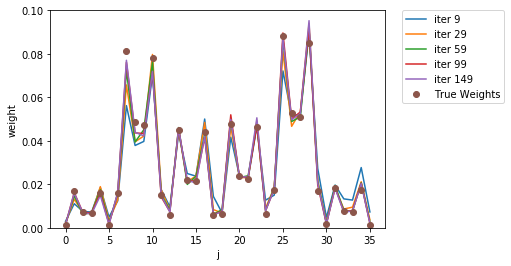

In [357]:
#Comparing the convergence of nu_tot for the basic and eig versions
stratified_data = stratified_data_2D_J_comparison[0]

weights_sum = (1. / 36.) * np.ones((n_iterations, 36))   #weights_sum[k] will be the sum of the first k weight vectors
weights_sum_eig = (1. / 36.) * np.ones((n_iterations,36))
for k in xrange(n_iterations - 1):
    weights_sum[k+1] = weights_sum[k] + np.array(stratified_data[2*k][2])
    weights_sum_eig[k+1] = weights_sum_eig[k] + np.array(stratified_data[2*k+1][2])
#    w=weights/(k+1.)
#    plt.plot(xrange(10), w, 'bo')
#    plt.show()
    
#    raw_input("Press Enter to continue...")

m = 5
for k in xrange(5):
    r = 5 * ((k+1)**2) + 5 * k + 4
    #plt.plot(xrange(64), weights_sum[r] / (r + 1.), label = 'iter ' + str(r))
    plt.plot(xrange(36), weights_sum_eig[r] / (r + 1.), label = 'iter ' + str(r))
    plt.ylim(0.,0.1)
    plt.xlabel('j')
    plt.ylabel('weight')
plt.plot(xrange(36), weights_true, 'o', label='True Weights')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#for k in xrange(50):
#Try: Series of basis functions
#Try: TV distance of histograms
#Try: Indicator functions on strata

#For different J, Try: Plot log(TV-distance), using histograms, as a line with negative slope, with time as the x-axis, and plot the lines for several J on the same graph

plt.show()

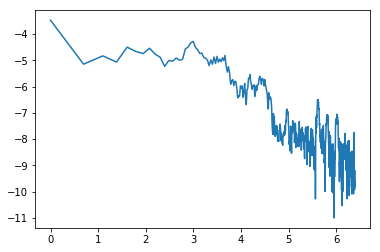

In [354]:
#Plotting tghe evolution of injection measures for stratified vs un-stratified
#For the un-stratified run, the injection measure is the empirical measure of all steps that transition between strata. Other steps are not counted, similar to estimating G in the un-stratified run. 
stratified_data = stratified_data_2D_J_comparison[0]
n_iterations = 600

#Compute the test function averages for the stratified run
test_sum_nu_eig = np.zeros((n_iterations, J, 3))
test_avg_nu_eig = np.zeros((n_iterations, J, 3))
test_sum_nu_eig_tot = np.zeros((n_iterations, 3))
test_avg_nu_eig_tot = np.zeros((n_iterations, 3))

nu_points_eig = stratified_data[1][0]
nu_probs_eig = stratified_data[1][1]
nu_weights_eig = stratified_data[1][2]
test_fcn_sum_current = np.zeros((J, 3))
test_fcn_sum_current_tot = np.zeros(3)
for j in xrange(J):
    n_points = len(nu_points_eig[j])
    for l in xrange(n_points):
        test_fcn_sum_current[j] += nu_probs_eig[j][l] * test_function_values(coef_1, coef_2, coef_3, nu_points_eig[j][l])
test_sum_nu_eig[0] = test_fcn_sum_current
test_avg_nu_eig[0] = test_sum_nu_eig[0]
for j in xrange(J):
    test_fcn_sum_current_tot += nu_weights[j] * test_fcn_sum_current[j]
test_sum_nu_eig_tot[0] = test_fcn_sum_current_tot
test_avg_nu_eig_tot[0] = test_sum_nu_eig_tot[0]

for i in xrange(n_iterations - 1):
    nu_points_eig = stratified_data[2*i+1][0]
    nu_probs_eig = stratified_data[2*i+1][1]
    nu_weights_eig = stratified_data[2*i+1][2]
    test_fcn_sum_current = np.zeros((J,3))
    test_fcn_sum_current_tot = np.zeros(3)
    for j in xrange(J):
        n_points = len(nu_points_eig[j])
        for l in xrange(n_points):
            test_fcn_sum_current[j] += nu_probs_eig[j][l] * test_function_values(coef_1, coef_2, coef_3, nu_points_eig[j][l])
    for j in xrange(J):
        test_fcn_sum_current_tot += nu_weights[j] * test_fcn_sum_current[j]
    test_sum_nu_eig[i+1] = test_sum_nu_eig[i] + test_fcn_sum_current
    test_avg_nu_eig[i+1] = test_sum_nu_eig[i+1] / (i + 2.)
    test_sum_nu_eig_tot[i+1] = test_sum_nu_eig_tot[i] + test_fcn_sum_current_tot
    test_avg_nu_eig_tot[i+1] = test_sum_nu_eig_tot[i+1] / (i+2.) 
    

plt.plot(np.log(xrange(n_iterations - 1)), [np.log(np.sum(abs(test_avg_nu_eig_tot[i+1] - test_avg_nu_eig_tot[i]))) for i in xrange(n_iterations - 1)])
plt.show()

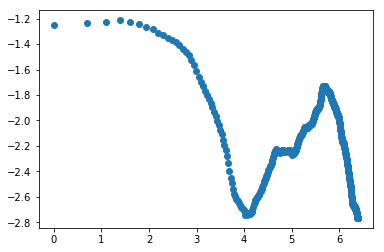

In [342]:
plt.plot(np.log(xrange(n_iterations)), [np.log(np.sum(abs(test_avg_nu_eig[k] - test_fcn_nu_avg_un_strat[239]))) for k in xrange(n_iterations)], 'o')

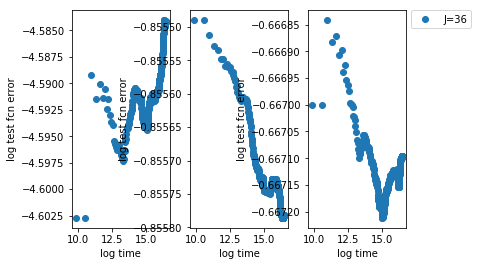

In [380]:
#This cell generates a graph for comparing performance across different values of J. 
iter_times = np.zeros(n_iterations)
iter_times_eig = np.zeros(n_iterations)

J = 36
stratified_data = stratified_data_2D_J_comparison[0]
for poly_num in xrange(3):

    test_avg = np.zeros(n_iterations)
    test_sum = 0.
    test_avg_eig = np.zeros(n_iterations)
    test_sum_eig = 0.

    nu_weights = stratified_data[0][2]
    time = stratified_data[0][4]
    for j in xrange(J):
        test_sum += np.array(nu_weights[j]) * stratified_data[0][3][j][poly_num] * (1. / time[j])
    test_avg[0] = test_sum

    nu_weights = stratified_data[1][2]
    time = stratified_data[1][4]
    for j in xrange(J):
        test_sum_eig += nu_weights[j] * stratified_data[0][3][j][poly_num] * (1. / time[j])
    test_avg_eig[0] = test_sum

    for k in xrange(n_iterations - 1):
        nu_weights = stratified_data[2*k][2]
        time = stratified_data[2*k][4]
        for j in xrange(J):
            test_sum += nu_weights[j] * stratified_data[2*k][3][j][poly_num] * (1. / time[j])
        test_avg[k+1] = test_sum / (k + 2.)
    
        nu_weights = stratified_data[2*k+1][2]
        time = stratified_data[2*k+1][4]
        for j in xrange(J):
            test_sum_eig += nu_weights[j] * stratified_data[2*k+1][3][j][poly_num] * (1. / time[j])
        test_avg_eig[k+1] = test_sum / (k + 2.)
    
    iter_times[0] = np.amax(np.array(stratified_data[0][4]))
    iter_times_eig[0] = np.amax(np.array(stratified_data[1][4]))
    for k in xrange(n_iterations - 1):
        iter_times[k+1] = iter_times[k] + np.amax(np.array(stratified_data[2*k][4]))
        iter_times_eig[k+1] = iter_times_eig[k] + np.amax(np.array(stratified_data[2*k+1][4]))
    
    m = 1
    l = n_iterations
    #plt.plot(np.log(iter_times[:l]), [np.log(abs(test_avg[k] - test_avg_un_strat[1199][3 * poly_num])) for k in xrange(l)], 'o', label = 'J=' + str(J))
    plt.subplot(1, 3, poly_num+1)
    plt.plot(np.log(iter_times_eig[:l]), [np.log(abs(test_avg_eig[k] - test_avg_un_strat[239][poly_num])) for k in xrange(l)], 'o', label = 'J=' + str(J))
    plt.xlabel('log time')
    plt.ylabel('log test fcn error') 
#Note: Run un-stratified again, but without re-starting at x_0 every 200 times, so that it is just the trajectory of a single particle

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()



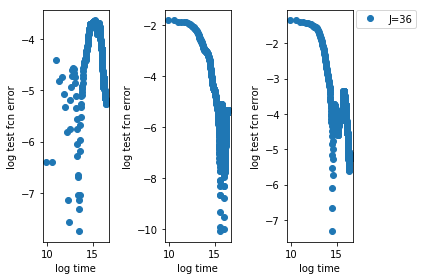

In [395]:
#This cell generates a graph for comparing performance across different values of J. 
iter_times = np.zeros(n_iterations)
iter_times_eig = np.zeros(n_iterations)

J = 36
stratified_data = stratified_data_2D_J_comparison[0]
for poly_num in xrange(3):
    
    iter_times[0] = np.amax(np.array(stratified_data[0][4]))
    iter_times_eig[0] = np.amax(np.array(stratified_data[1][4]))
    for k in xrange(n_iterations - 1):
        iter_times[k+1] = iter_times[k] + np.amax(np.array(stratified_data[2*k][4]))
        iter_times_eig[k+1] = iter_times_eig[k] + np.amax(np.array(stratified_data[2*k+1][4]))
    
    m = 1
    l = n_iterations
    #plt.plot(np.log(iter_times[:l]), [np.log(abs(test_avg[k] - test_avg_un_strat[1199][3 * poly_num])) for k in xrange(l)], 'o', label = 'J=' + str(J))
    plt.subplot(1, 3, poly_num+1)
    plt.plot(np.log(iter_times_eig[:l]), [np.log(abs(test_avg_nu_eig_tot[k][poly_num] - test_avg_un_strat[239][poly_num])) for k in xrange(l)], 'o', label = 'J=' + str(J))
    plt.xlabel('log time')
    plt.ylabel('log test fcn error') 
#Note: Run un-stratified again, but without re-starting at x_0 every 200 times, so that it is just the trajectory of a single particle

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

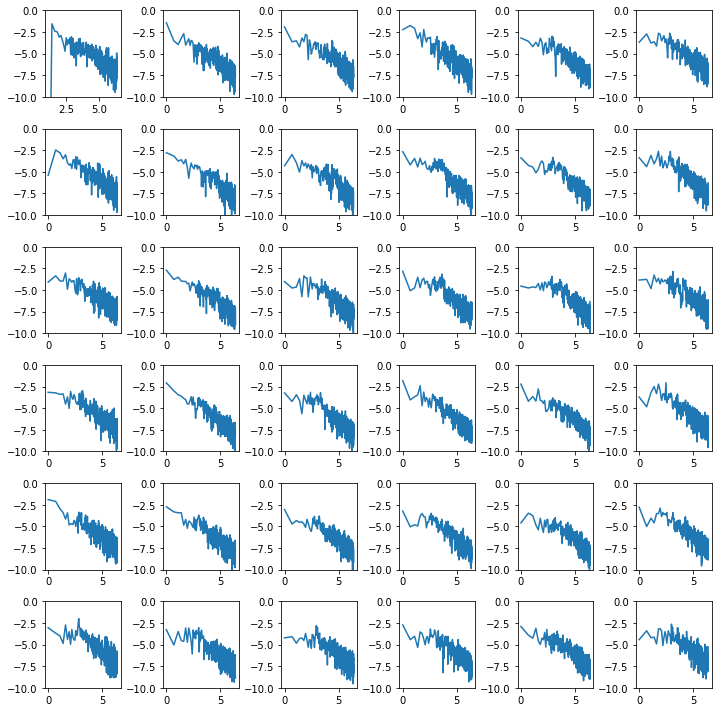

In [396]:
K=6
plt.figure(figsize = (10,10))
for l in xrange(K):
    for k in xrange(K):
        j = l * K + k
    
        plt.subplot(K,K,j+1)
        #plt.figure(figsize = (10,10))
        plt.ylim(-10., 0.)
        plt.plot(np.log(xrange(n_iterations - 1)), [np.log(np.sum(abs(test_avg_nu_eig[i+1][j] - test_avg_nu_eig[i][j]))) for i in xrange(n_iterations - 1)])
plt.tight_layout()
#plt.show()

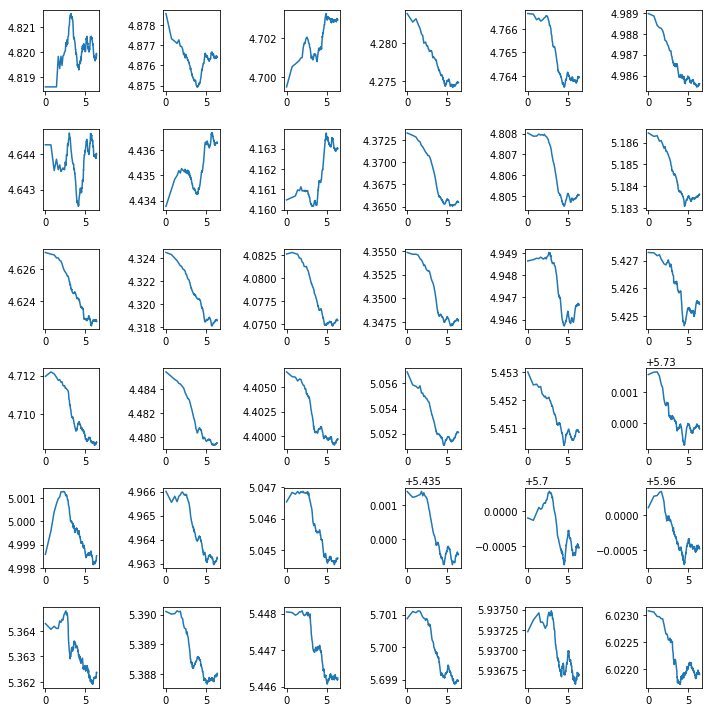

In [402]:
#Plot the non-time-averaged weights on each stratum
#Look into why the first iteration time seems so large

K=6
plt.figure(figsize = (10,10))
for l in xrange(K):
    for k in xrange(K):
        j = l * K + k
    
        plt.subplot(K,K,j+1)
        #plt.figure(figsize = (10,10))
        #plt.ylim()
        plt.plot(np.log(xrange(n_iterations)), [np.log(np.sum(abs(test_avg_nu_eig[i][j] - test_fcn_nu_un_strat_one_stratum_avg[239][j]))) for i in xrange(n_iterations)])
plt.tight_layout()
#plt.show()

In [ ]:
#This cell plots the convergence of a test function


In [189]:
#On each iteration, calculate the expected time to exit, make h small enough and keep it constnat for all J
#Plot log TV distance vs. average exit time for each iteration

#Try: Noise on other coordinates, indirect in x0
#Try: 3d strata in lorenz 63
#Try: other places to put the strata midpoints
#Make a repository of all plots we want to use in the thesis
#Note: when making all the noise indirect, the exit times increased greatly. For now, I'll do more simulations with noise in X_0

#Make movie with heat map of un-strat and strat histograms
#Plot error with a choice of high-dimensional test functions
#Change end points of strata, so they don't line up with the bottoms of the wells (both perfectly centered and not)

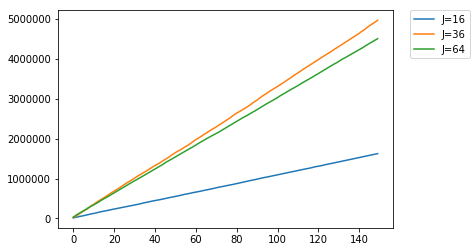

In [230]:
for j in xrange(3):
    J = (4 + 2*j)**2
    #plt.plot(xrange(150), iter_times[j], label = 'J=' + str(J))
    plt.plot(xrange(150), iter_times_eig[j], label = 'J=' + str(J))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [94]:
#weights = [.125, .125, .125, .125, .125, .125, .125, .125]
#for m in xrange(300):
#    weights += stratified_data[1][m][2] 
#    w=weights/(m+1.)
#    plt.plot(xrange(8), w, 'o')
#    plt.show()
#    
#    raw_input("Press Enter to continue...")

In [8]:
#This cell is for testing the creating of a movie with moviepy.editor.VideoClip and a make_frame function
#note: t ranges from 0 to duration, in increments of 1/fps. Make sure that it lines up with the number of plots to be used,
#So that you can call a new iteration of the algorithm for each new frame. E.g. here, duration = 3 and fps=10, and t_range
#has 30 values, so the video goes through all 30 plots in 3 seconds. 
t_range = np.arange(0.0, 3.0, 0.1)

duration = 3
fig, ax = plt.subplots()
def make_frame(t):
    ax.clear()
    x = bin_edges[1:]
    t_current = t_range[int(t * 10)]
    ax.plot(x, t_current * x**2, 'o')
    ax.set_ylim(0.0, 3.0)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
animation.ipython_display(fps=int(len(t_range) / duration), loop=True, autoplay=True)

Text(0.5,0,'z')

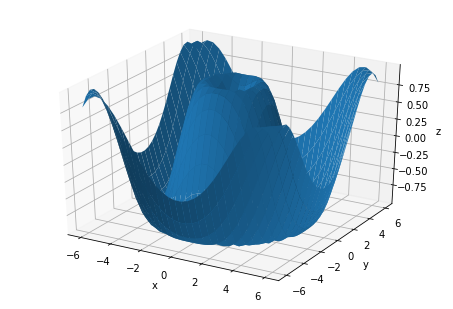

In [2]:
#Test for 3d plotting
fig = plt.figure()

ax = Axes3D(fig)
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)
ax.plot_surface(X, Y, Z)
#ax.scatter(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


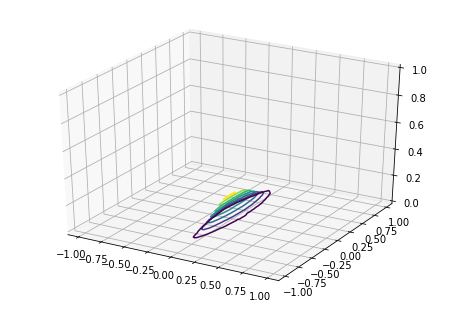

In [13]:
#Create video of 3d plots from the stratified data
#Joint Distribution of X_0, X_1 for 4 noise

duration = 29.9
#fig, ax = plt.subplots()
fig = plt.figure()
ax = Axes3D(fig)
def make_frame(t):
    ax.clear()
    m = int(t * 10)
    ax.contour3D(bin_edges[1:], bin_edges[1:], stratified_mixed_hist[m])
    #ax.plot(bin_edges[1:], stratified_mixed_hist[m], 'o')
    ax.set_zlim(0.0, 1.0)
    #ax.set_ylim(0.0, 1.7)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
animation.ipython_display(fps=10, loop=True, autoplay=True)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4




t:  90%|████████▉ | 268/299 [00:32<00:03,  9.15it/s, now=None]


t: 100%|██████████| 299/299 [00:36<00:00,  8.61it/s, now=None]
                                                              

Moviepy - Done !
Moviepy - video ready __temp__.mp4


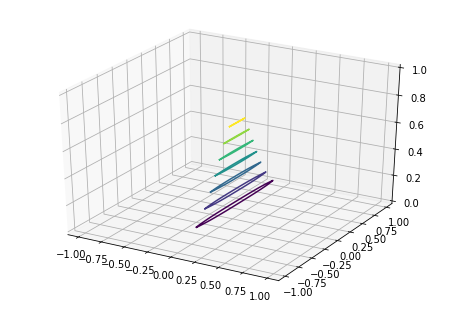

In [90]:
#Create video of 3d plots from the stratified data
#Joint Distribution of X_0, X_19 for 4 noise

duration = 29.9
#fig, ax = plt.subplots()
fig = plt.figure()
ax = Axes3D(fig)
def make_frame(t):
    ax.clear()
    m = int(t * 10)
    ax.contour3D(bin_edges[1:], bin_edges[1:], stratified_mixed_hist[m])
    #ax.plot(bin_edges[1:], stratified_mixed_hist[m], 'o')
    ax.set_zlim(0.0, 1.0)
    #ax.set_ylim(0.0, 1.7)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
animation.ipython_display(fps=10, loop=True, autoplay=True)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4




t:  88%|████████▊ | 262/299 [00:34<00:04,  8.35it/s, now=None]


t: 100%|██████████| 299/299 [00:38<00:00,  8.75it/s, now=None]
                                                              

Moviepy - Done !
Moviepy - video ready __temp__.mp4


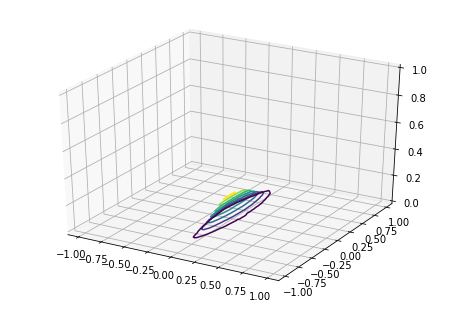

In [96]:
#Joint Distribution of X_0, X_4 for 4 noise

duration = 29.9
#fig, ax = plt.subplots()
fig = plt.figure()
ax = Axes3D(fig)
def make_frame(t):
    ax.clear()
    m = int(t * 10)
    ax.contour3D(bin_edges[1:], bin_edges[1:], stratified_mixed_hist[m])
    #ax.plot(bin_edges[1:], stratified_mixed_hist[m], 'o')
    ax.set_zlim(0.0, 1.0)
    #ax.set_ylim(0.0, 1.7)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
animation.ipython_display(fps=10, loop=True, autoplay=True)